# Convergence testing

We've noticed that our models fits are still not converging after 10000 iterations. There are two potential solutions we'll try here:

1. Adding a small L2 (ridge) to all parameters in the model.
2. Warming up beta's to the reference data alone.

In [62]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Read in the dms data and list all available experimental conditions**

In [15]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../data/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../data/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [16]:
print(f"Available conditions for fitting are: {list(func_score_data.condition.unique())}")

Available conditions for fitting are: ['Delta-1', 'Delta-3', 'Delta-4', 'Delta-2', 'Omicron_BA1-1', 'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2']


## Pre-Proccessing

In [17]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.aa_substitutions.fillna("", inplace=True)
func_score_df.sort_values(by="condition", inplace=True)
func_score_df.info()

  0%|          | 0/16 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135096 entries, 0 to 1135095
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   library                      1135096 non-null  object 
 1   pre_sample                   1135096 non-null  object 
 2   post_sample                  1135096 non-null  object 
 3   barcode                      1135096 non-null  object 
 4   func_score                   1135096 non-null  float64
 5   func_score_var               1135096 non-null  float64
 6   pre_count                    1135096 non-null  int64  
 7   post_count                   1135096 non-null  int64  
 8   pre_count_wt                 1135096 non-null  int64  
 9   post_count_wt                1135096 non-null  int64  
 10  pseudocount                  1135096 non-null  float64
 11  n_codon_substitutions        1135096 non-null  int64  
 12  aa_substitutions_sequential  986419 non-nu

In [18]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "pseudocount" : 0.1,
    "sample" : False,
    "min_pre_counts" : 100, # "bernadeta",
    "clip_target" : (-3.5, 2.5),
    "trim" : False
}

**Optionally subset the variants**

In [19]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

In [20]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23,Delta,1,Delta-1
60179,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,GAATGGTATGGCCGCG,0.4364,0.0089,521,428,1154532,701032,0.5,7,L10V G75D Y447N R680W A827S A1018D V1226E,7,L10V G75D Y449N R682W A829S A1020D V1228E,23,Delta,2,Delta-1
60178,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CTGTCTAACGCCTACC,-1.8556,0.0278,521,87,1154532,701032,0.5,5,P25S Y363H A769N S811P,4,P25S Y365H A771N S813P,23,Delta,2,Delta-1
60177,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CGGCGTGACTCAATTC,-0.0470,0.0108,521,306,1154532,701032,0.5,1,R679S,1,R681S,23,Delta,2,Delta-1
60176,Lib-1,2021-10-28_thaw-1_VSVG_control_2,2021-12-14_thaw-1_no-antibody_control_2,CGCACCAAAATTACAT,1.2236,0.0068,521,739,1154532,701032,0.5,3,V70N S98G V143I,3,V70N S98G V143I,23,Delta,2,Delta-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930493,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAAGAACCAATACCTA,-0.7129,0.0183,287,187,9244303,9882108,0.5,4,P79S S109T D135T K1035N,4,P82S S112T D138T K1038N,69,Omicron_BA2,1,Omicron_BA2-2
930494,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAAGAGTAGTTTATGC,-0.8500,0.0194,287,170,9244303,9882108,0.5,4,L176P A219T G258H N402D,4,L179P A222T G261H N405D,69,Omicron_BA2,1,Omicron_BA2-2
930495,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAATATATGCCCAAAC,-2.3933,0.0428,287,58,9244303,9882108,0.5,2,S24F G410E,2,S27F G413E,69,Omicron_BA2,1,Omicron_BA2-2
930497,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,AAATTAAGTTTGATAA,0.6685,0.0115,287,488,9244303,9882108,0.5,2,A219V S1239I,2,A222V S1242I,69,Omicron_BA2,1,Omicron_BA2-2


**Drop all variants with pre-counts below a threshold.**

In [21]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
if prep_params["min_pre_counts"] == "bernadeta":
    func_score_df = func_score_df[func_score_df['pre_count'] >= func_score_df['pre_count_threshold']]
else:
    func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]

print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 1135096 variants, 120164 had fewer than the threshold of counts before selection, and were filtered out


In [22]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**remove all variants with string sites and stop codon wildtypes**

In [23]:
func_score_df.aa_substitutions.fillna("", inplace=True)
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1014932 [00:00<?, ?it/s]

In [24]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

**Optionally, clip the target functional scores**

In [25]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [26]:
func_score_df.condition.unique()

array(['Delta-1', 'Delta-2', 'Delta-3', 'Delta-4', 'Omicron_BA1-1',
       'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2'],
      dtype=object)

## Experiments

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [285]:
datasets = pd.DataFrame()

## `MultiDmsData`

In [209]:
# uncomment to see docs
# help(multidms.MultiDmsData)

**After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.**

Separate the functional dataframe into two replicate sets of your choosing. These replicates will be fit separatelty, with the parameters results averaged.

## Hueristic 1

First, we'll just try fitting two homologs, Delta, and BA1. We will do two separate fits -- each with a set of independent biological replicates (libraries) as the data. 

In [210]:
rep1_name_map = {
    "Delta-3":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1"
#     "Omicron_BA.2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1"
#     "Omicron_BA.2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

for reference in ["Delta", "Omicron_BA1"]:
    for rep_fsdf in [fs_rep1, fs_rep2]:       
        
        start = time.time()
        data = multidms.MultiDmsData(
            rep_fsdf,
            alphabet= multidms.AAS_WITHSTOP_WITHGAP,
            condition_colors = sns.color_palette("colorblind"),
            reference=reference,
            assert_site_integrity = False,
            verbose=False
        )
        
        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")
        
        prep_params['conditions'] = tuple(rep_fsdf.condition.unique())
        prep_params['time_to_prep'] = prep_time
        prep_params['reference'] = reference
        data_row = pd.Series(prep_params).to_frame().T
        data_row['data'] = data
        datasets = pd.concat([datasets, data_row], ignore_index=True)
    

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 45
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 42
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 50
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 39


In [211]:
datasets

,scale_counts,pseudocount,sample,min_pre_counts,clip_target,trim,conditions,time_to_prep,reference,data
0,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",45,Delta,<multidms.data.MultiDmsData object at 0x7f73fb...
1,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",42,Delta,<multidms.data.MultiDmsData object at 0x7f741d...
2,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",50,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f7ec6...
3,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",39,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f7639...


In [262]:
import matplotlib.colors as colors

palette = [
    '#BFBFBF',#,'#404040',
    '#F97306',#, '#FFA500',
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [263]:
imodel.params

{'β': DeviceArray([-1.6906357 , -2.11481281, -1.05181325, ...,  0.31411314,
              -0.41324319, -0.38428203], dtype=float64),
 'S_Delta': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Delta': DeviceArray([0.], dtype=float64),
 'S_Omicron_BA1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Omicron_BA1': DeviceArray([0.], dtype=float64),
 'C_ref': DeviceArray([5.], dtype=float64),
 'α': {'ghost_param': DeviceArray([0.], dtype=float64)},
 'γ_Delta': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA1': DeviceArray([0.], dtype=float64)}

**let's start by a simple warmup linear model the betas for the model**

In [509]:
fit_attributes = {
    "lasso_shift" : 2e-5
}
            
imodel = multidms.MultiDmsModel(
    datasets.loc[0, 'data'],
    epistatic_model=multidms.model.identity_activation,
    output_activation=multidms.model.identity_activation,
    conditional_c=False,
    gamma_corrected=True,
    init_C_ref=0.0
)

imodel.fit_reference_beta()

In [510]:
imodel.params

{'β': DeviceArray([-1.69063584, -2.1148132 , -1.0518135 , ...,  0.31411349,
              -0.41324336, -0.38428279], dtype=float64),
 'S_Delta': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Delta': DeviceArray([0.], dtype=float64),
 'S_Omicron_BA1': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'C_Omicron_BA1': DeviceArray([0.], dtype=float64),
 'C_ref': DeviceArray([0.], dtype=float64),
 'α': {'ghost_param': DeviceArray([0.], dtype=float64)},
 'γ_Delta': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA1': DeviceArray([0.], dtype=float64)}

Beta's were the only parameter changed, and so we expect our latent reference phenotype to be 5.

In [511]:
imodel.wildtype_df

,predicted_latent,predicted_func_score
Delta,0.000000,0.000000
Omicron_BA1,-3.757271,-3.757271


Notice the latent phenotype prediction for _Omicron\_BA1_ $\approx 1.24$. This means the additive model for Delta predicts $\approx -3.75$

**Plot the Delta linear model against the true values for both Delta and Omicron**

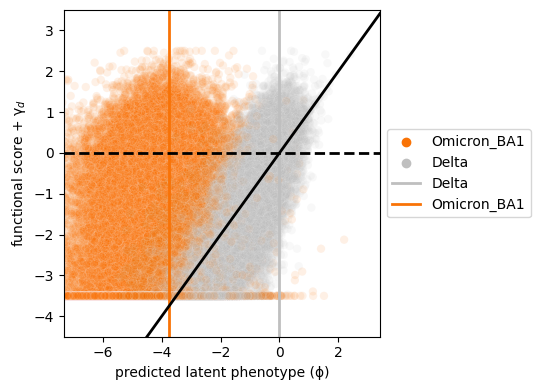

In [512]:
fig, ax = plt.subplots(figsize=[4,4])
imodel.plot_epistasis(ax=ax, show=False, alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Let's try and fit the shifts $S_{BA1}$, latent bias $C_{ref}$, and $γ_{BA1}$, for Omicron, Locking our beta's to their current values** 

In [513]:
lock_params = {
    "β" : imodel.params["β"]
}

start = time.time()
imodel.fit(
    lasso_shift=2e-5,
    maxiter=1000, 
    tol=1e-6,
    λ_ridge=0.0,
    lock_params=lock_params
)
end = time.time()
fit_time = round(end - start)

In [515]:
imodel.params

{'C_Delta': DeviceArray([0.], dtype=float64),
 'C_Omicron_BA1': DeviceArray([0.], dtype=float64),
 'C_ref': DeviceArray([-0.05130219], dtype=float64),
 'S_Delta': DeviceArray([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'S_Omicron_BA1': DeviceArray([0.        , 0.        , 0.        , ..., 0.37571167,
              0.35525183, 0.        ], dtype=float64),
 'α': {'ghost_param': DeviceArray([0.], dtype=float64)},
 'β': DeviceArray([-1.69063584, -2.1148132 , -1.0518135 , ...,  0.31411349,
              -0.41324336, -0.38428279], dtype=float64),
 'γ_Delta': DeviceArray([0.], dtype=float64),
 'γ_Omicron_BA1': DeviceArray([2.24685467], dtype=float64)}

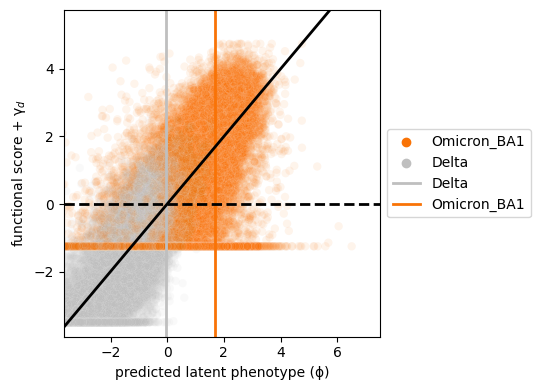

In [516]:
fig, ax = plt.subplots(figsize=[4,4])
imodel.plot_epistasis(ax=ax, show=False, alpha=0.08)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

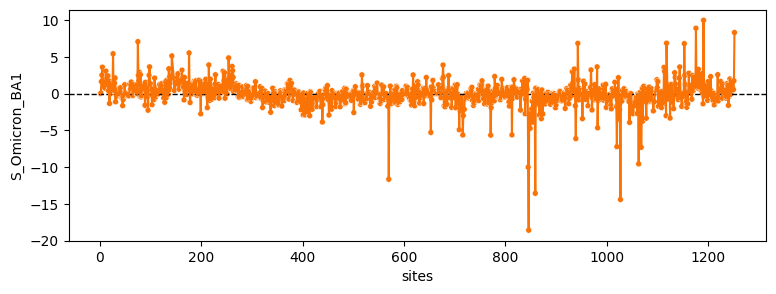

In [363]:
fig, ax = plt.subplots(figsize=[9,3])
imodel.plot_shifts_by_site("Omicron_BA1",ax=ax, show=False, agg_func=onp.sum)
plt.show()

In [ ]:
loss_dict = {}
lasso_dict["iteration"] = 

In [517]:
fit_attributes = {
    "lasso_shift" : 2e-5
}
            
model_beta_then_shift = multidms.MultiDmsModel(
    datasets.loc[0, 'data'],
    epistatic_model=multidms.model.identity_activation,
    output_activation=multidms.model.identity_activation,
    conditional_c=True,
    gamma_corrected=False,
    init_C_ref=0.0
)

imodel.fit_reference_beta()

lock_params = {
    "β" : model_beta_then_shift.params["β"],
    "C_ref" : jnp.zeros(shape=(1,))
}
iterations, loss = [], []
for training_step in range(10):
    start = time.time()
    model_beta_then_shift.fit(
        lasso_shift=2e-5,
        maxiter=1000, 
        tol=1e-6,
        λ_ridge=0.0,
        lock_params=lock_params
    )
    end = time.time()
    fit_time = round(end - start)
    print(
        f"training_step {training_step+1}/10, Loss: {model_beta_then_shift.loss}, Time: {fit_time} Seconds",
        flush=True
    )
    
    
    iterations.append(1000 * (training_step+1))
    loss.append(model_beta_then_shift.loss)

training_step 1/10, Loss: 0.7591173023051407, Time: 18 Seconds
training_step 2/10, Loss: 0.7241882760357519, Time: 17 Seconds
training_step 3/10, Loss: 0.708000736599748, Time: 17 Seconds
training_step 4/10, Loss: 0.6990036353576596, Time: 17 Seconds
training_step 5/10, Loss: 0.693182364555265, Time: 17 Seconds
training_step 6/10, Loss: 0.6890732606718428, Time: 17 Seconds
training_step 7/10, Loss: 0.6860194626564038, Time: 17 Seconds
training_step 8/10, Loss: 0.6835622488947415, Time: 17 Seconds
training_step 9/10, Loss: 0.6816483821650794, Time: 17 Seconds
training_step 10/10, Loss: 0.6802035009491654, Time: 17 Seconds


In [ ]:
fig, ax = plt.subplots(figsize=[4,4])
model_beta_then_shift.plot_epistasis(ax=ax, show=False, alpha=0.08)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Let's train those same parameters for another couple sets of 1000 iterations, and see if it converges**

In [389]:
fit_attributes = {
    "lasso_shift" : 2e-5
}
            
model_beta_then_shift = multidms.MultiDmsModel(
    datasets.loc[0, 'data'],
    epistatic_model=multidms.model.identity_activation,
    output_activation=multidms.model.identity_activation,
    conditional_c=False,
    gamma_corrected=True,
    init_C_ref=5.0
)

model_beta_then_shift.fit_reference_beta()

lock_params = {
    "β" : model_beta_then_shift.params["β"]
}
iterations, loss = [], []
for training_step in range(10):
    start = time.time()
    model_beta_then_shift.fit(
        lasso_shift=2e-5,
        maxiter=1000, 
        tol=1e-6,
        λ_ridge=0.0,
        lock_params=lock_params
    )
    end = time.time()
    fit_time = round(end - start)
    print(
        f"training_step {training_step+1}/10, Loss: {model_beta_then_shift.loss}, Time: {fit_time} Seconds",
        flush=True
    )
    iterations.append(1000 * training_step)
    loss.append(model_beta_then_shift.loss)

training_step 1/10, Loss: 0.761707008553965, Time: 19 Seconds
training_step 2/10, Loss: 0.7240389488264042, Time: 17 Seconds
training_step 3/10, Loss: 0.7059621734979301, Time: 17 Seconds
training_step 4/10, Loss: 0.6963311691292302, Time: 17 Seconds
training_step 5/10, Loss: 0.6903761191310835, Time: 17 Seconds
training_step 6/10, Loss: 0.6864691141466155, Time: 17 Seconds
training_step 7/10, Loss: 0.6835934722370447, Time: 17 Seconds
training_step 8/10, Loss: 0.6814509434701492, Time: 17 Seconds
training_step 9/10, Loss: 0.6798078055194944, Time: 17 Seconds
training_step 10/10, Loss: 0.6785424629260617, Time: 17 Seconds


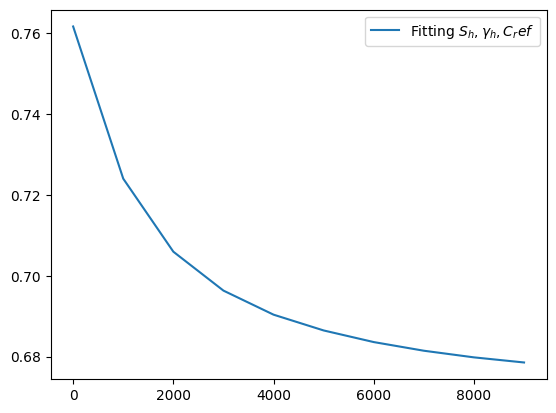

In [390]:
fig, ax = plt.subplots()
ax.plot(iterations, loss, label="Fitting $S_h, \gamma_{h}, C_{ref}$")
ax.legend()
plt.show()

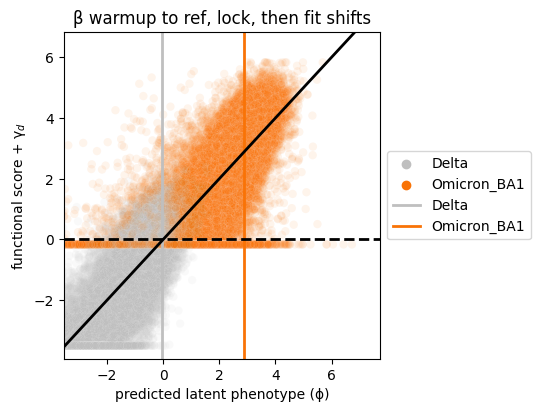

In [391]:
fig, ax = plt.subplots(figsize=[4,4])
model_beta_then_shift.plot_epistasis(ax=ax, show=False, alpha=0.08)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("β warmup to ref, lock, then fit shifts")
plt.show()

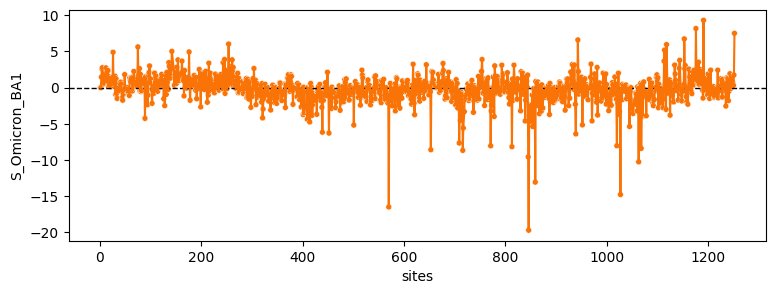

In [392]:
fig, ax = plt.subplots(figsize=[9,3])
model_beta_then_shift.plot_shifts_by_site("Omicron_BA1",ax=ax, show=False, agg_func=onp.sum)
plt.show()

**Let's compare this to no warmup, full model fit.**

In [404]:
fit_attributes = {
    "lasso_shift" : 2e-5
}
            
model_full_fit = multidms.MultiDmsModel(
    datasets.loc[0, 'data'],
    epistatic_model=multidms.model.identity_activation,
    output_activation=multidms.model.identity_activation,
    conditional_c=False,
    gamma_corrected=True,
    init_C_ref=5.0
)

# model_full_fit.fit_reference_beta()

lock_params = {
}
iterations_full, loss_full = [], []
for training_step in range(10):
    start = time.time()
    model_full_fit.fit(
        lasso_shift=2e-5,
        maxiter=1000, 
        tol=1e-6,
        λ_ridge=0.0,
        lock_params=lock_params
    )
    end = time.time()
    fit_time = round(end - start)
    print(
        f"training_step {training_step+1}/10, Loss: {model_full_fit.loss}, Time: {fit_time} Seconds",
        flush=True
    )
    iterations_full.append(1000 * training_step)
    loss_full.append(model_full_fit.loss)

training_step 1/10, Loss: 0.9136670761708936, Time: 19 Seconds
training_step 2/10, Loss: 0.8030706084172617, Time: 17 Seconds
training_step 3/10, Loss: 0.7556629416083831, Time: 17 Seconds
training_step 4/10, Loss: 0.7289538144876361, Time: 17 Seconds
training_step 5/10, Loss: 0.711532076415035, Time: 17 Seconds
training_step 6/10, Loss: 0.6990423238991574, Time: 17 Seconds
training_step 7/10, Loss: 0.689595062438281, Time: 17 Seconds
training_step 8/10, Loss: 0.6827193369457043, Time: 17 Seconds
training_step 9/10, Loss: 0.6775495450545826, Time: 17 Seconds
training_step 10/10, Loss: 0.6735184206026628, Time: 17 Seconds


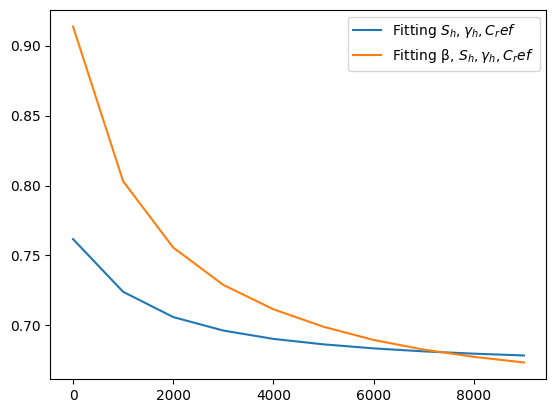

In [426]:
fig, ax = plt.subplots()
ax.plot(iterations, loss, label="Fitting $S_h, \gamma_{h}, C_ref$")
ax.plot(iterations_full, loss_full, label="Fitting β, $ S_h, \gamma_{h}, C_ref$")
ax.legend()
plt.show()

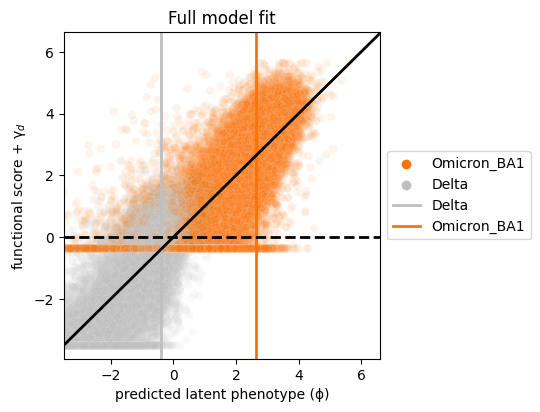

In [407]:
fig, ax = plt.subplots(figsize=[4,4])
model_full_fit.plot_epistasis(ax=ax, show=False, alpha=0.08)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Full model fit")
plt.show()

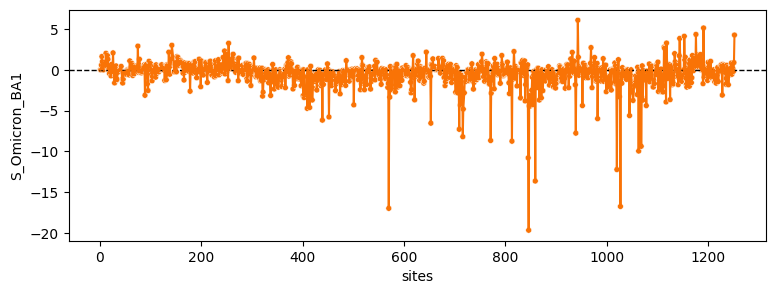

In [408]:
fig, ax = plt.subplots(figsize=[9,3])
model_full_fit.plot_shifts_by_site("Omicron_BA1",ax=ax, show=False, agg_func=onp.sum)
plt.show()

It doesn't seem as though the warmup does much for us. 

**Next, let's see how a uniform ridge (L1) penalty compares across a few values. Since we're comparing models, we'll define two wrapper functions for fitting given some parameters, as well as plotting the loss of those models.**

In [409]:
datasets

,scale_counts,pseudocount,sample,min_pre_counts,clip_target,trim,conditions,time_to_prep,reference,data
0,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",45,Delta,<multidms.data.MultiDmsData object at 0x7f73fb...
1,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",42,Delta,<multidms.data.MultiDmsData object at 0x7f741d...
2,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",50,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f7ec6...
3,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",39,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f7639...


In [611]:
def fit_wrapper(
    dataset,
    δ_huber = 1,
    λ_lasso_shift = 2e-5,
    λ_ridge_all = 1e-6,
    data_idx = 0,
    epistatic_model = "identity",
    output_activation = "identity",
    lock_beta = False, 
    lock_C_ref = False,
    gamma_corrected = True,
    conditional_c = False,
    init_C_ref = 0.0,
    warmup_beta = False
):
    biophysical_model = {
        "identity" : multidms.model.identity_activation,
        "Sigmoid" : multidms.model.sigmoidal_global_epistasis,
        "Softplus" : multidms.model.softplus_activation
    }
    
    fit_attributes = locals().copy()
    
    imodel = multidms.MultiDmsModel(
        dataset,
        epistatic_model=biophysical_model[fit_attributes['epistatic_model']],
        output_activation=biophysical_model[fit_attributes['output_activation']],
        conditional_c=fit_attributes['conditional_c'],
        gamma_corrected=fit_attributes['gamma_corrected'],
        init_C_ref=fit_attributes['init_C_ref']
    )

    if fit_attributes["warmup_beta"]:
        imodel.fit_reference_beta()

    lock_params = {}
    if fit_attributes["lock_beta"]:
        lock_params["β"] = imodel.params["β"]

    if fit_attributes["lock_C_ref"]:
        lock_params["C_ref"] = jnp.zeros(shape=(1,))

    fit_attributes['epoch_loss'] = []
    print(f"running:")
    pprint.pprint(fit_attributes)

    fit_attributes["total_iterations"] = 0
    ret = pd.DataFrame()

    for training_step in range(20):

        start = time.time()
        imodel.fit(
            lasso_shift=fit_attributes['λ_lasso_shift'],
            maxiter=1000, 
            tol=1e-6,
            λ_ridge=fit_attributes['λ_ridge_all'],
            δ=fit_attributes["δ_huber"],
            lock_params=lock_params
        )
        end = time.time()

        fit_time = round(end - start)
        fit_attributes['total_iterations'] += 1000
        fit_attributes['epoch_loss'].append(float(imodel.loss))

        print(
            f"training_step {training_step}/10, Loss: {imodel.loss}, Time: {fit_time} Seconds",
            flush=True
        )

        if fit_attributes['total_iterations'] in [1000, 5000, 10000, 20000]:
            data_row = pd.Series(fit_attributes).to_frame().T
            data_row["model_object"] = copy.copy(imodel)
            ret = pd.concat([ret, data_row], ignore_index=True)
            
    return ret


def plot_loss(models):

    fig, ax = plt.subplots(figsize=[7,7])
    iterations = [(i+1)*1000 for i in range(20)]
    for group, group_models in models.groupby(
        ['λ_ridge_all', 'total_iterations', 'warmup_beta', 'lock_beta', 'conditional_c', 'δ_huber']
    ):
        if group[1] != 20000: continue
        style = "-"
        lp = "linear model"

        for mt, mt_df in group_models.groupby(["epistatic_model", "output_activation"]):

            assert len(mt_df) == 1
            if mt != ("identity", "identity"):
                style = "--"
                lp = "\n".join(mt)

            lw = 3 if group[5] != 3 else 5

            loss = mt_df['epoch_loss'].values

            ax.plot(
                iterations, 
                loss[0],
                lw=lw,
                linestyle = style,
                label=f"{lp}\nλ ridge: {group[0]} | warmup: {group[2]}\nlock_beta: {group[3]} | conditional_c: {group[4]}\nδ_huber:{group[5]}"
            )

    ax.set_ylabel(f"Loss")
    ax.set_xlabel(f"Iterations")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [596]:
import pprint
import copy

In [597]:
# models

**Let's test a few ridge parameter values, and compare the loss**

In [ ]:
ridge_models = pd.DataFrame()
for ridge in [0, 1e-6, 1e-5, 1e-4]:
    new = {'λ_ridge_all':ridge}
    ridge_models = pd.concat([
        ridge_models,
        fit_wrapper(datasets.loc[0, "data"], **new),
    ])
# plot_loss(ridge_models)

running:
{'biophysical_model': {'Sigmoid': <CompiledFunction of <function sigmoidal_global_epistasis at 0x7f7f348da170>>,
                       'Softplus': <CompiledFunction of <function softplus_activation at 0x7f7f348d95a0>>,
                       'identity': <CompiledFunction of <function identity_activation at 0x7f7ff9f90040>>},
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f73fb8cd180>,
 'epistatic_model': 'identity',
 'epoch_loss': [],
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'lock_C_ref': False,
 'lock_beta': False,
 'output_activation': 'identity',
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_all': 0}
training_step 0/10, Loss: 0.9131177468473699, Time: 18 Seconds


Looks as though the primary ridge which actually made a difference was the 1e-4. However it seems the string lasso underfit to the data

**Does locking the beta (exclusively after reference beta warmup) effect things? I expect not given our previous example above**

In [ ]:
new = {
    "warmup_beta" : True,
    "gamma_corrected" : False,
    "conditional_c" : True
}
lock_beta_models = pd.DataFrame()
for lock_beta in [True, False]:
    new["lock_beta"] = lock_beta
    lock_beta_models = pd.concat([
        lock_beta_models,
        fit_wrapper(datasets.loc[0, "data"], **new),
    ])
# plot_loss(lock_beta_models)    

**How about a using `C_h` instead of `γ_h` + `C_ref`**?

In [ ]:
new = {
    "lock_C_ref" : True,
    "gamma_corrected" : False,
    "conditional_c" : True
}
Ch_models = fit_wrapper(datasets.loc[0, "data"], **new)
# plot_loss(Ch_models)

**Non-Linear models?**

In [ ]:
non_lin_models = pd.DataFrame()
for output in ["identity", "Softplus"]:
    new = {
        "epistatic_model" : "Sigmoid",
        "output_activation" : output
    }
    im = fit_wrapper(datasets.loc[0, "data"], **new)
    non_lin_models = pd.concat([im, non_lin_models], ignore_index=True)
# plot_loss(Ch_models)

**What about the huber scaling? Could increased residuals speed things up?**

In [ ]:
new = {
    'δ_huber' : 3
}
huber_scaling_models = fit_wrapper(datasets.loc[0, "data"], **new)
# plot_loss(huber_scaling_models)

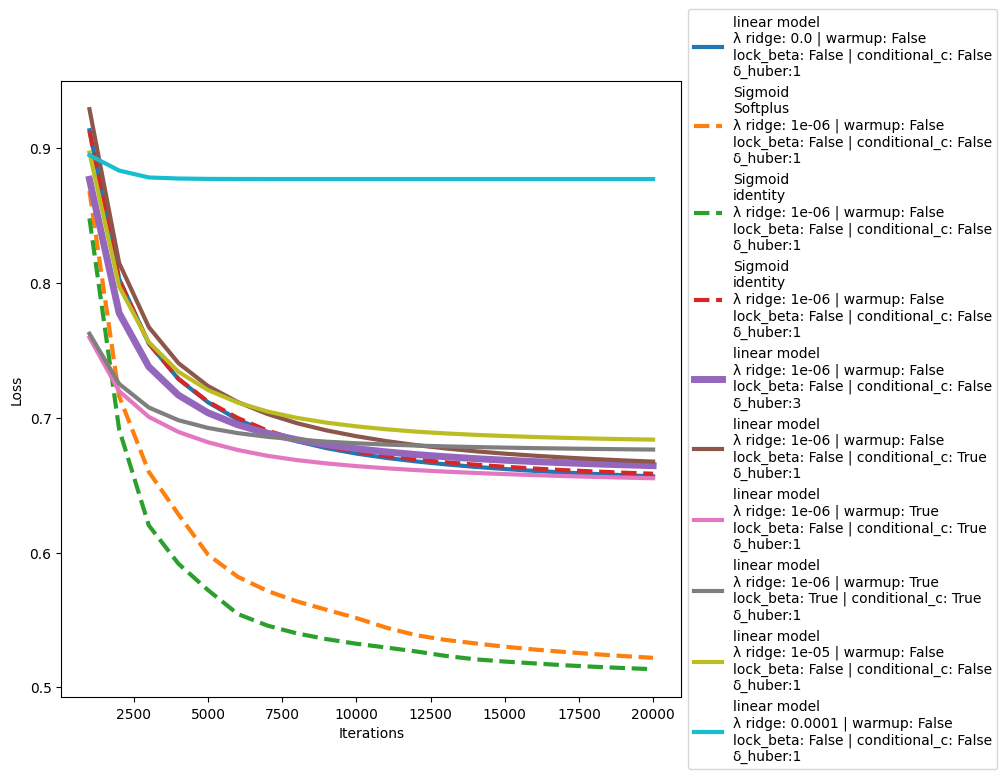

In [610]:
plot_loss(pd.concat([
    non_lin_models,
    ridge_models,
    lock_beta_models,
    Ch_models,
    huber_scaling_models 
]))

In [605]:
datasets

,scale_counts,pseudocount,sample,min_pre_counts,clip_target,trim,conditions,time_to_prep,reference,data
0,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",45,Delta,<multidms.data.MultiDmsData object at 0x7f73fb...
1,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",42,Delta,<multidms.data.MultiDmsData object at 0x7f741d...
2,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",50,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f7ec6...
3,False,0.1,False,100,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",39,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f7639...


In [ ]:
all_models = pd.concat([
    non_lin_models,
    ridge_models,
    lock_beta_models,
    Ch_models,
    huber_scaling_models 
])
for idx, row in all_models.iterrows():
    fig, ax = plt.subplots(figsize=[4,4])
    row.model_object.plot_pred_accuracy(ax=ax, show=False, alpha=0.08)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

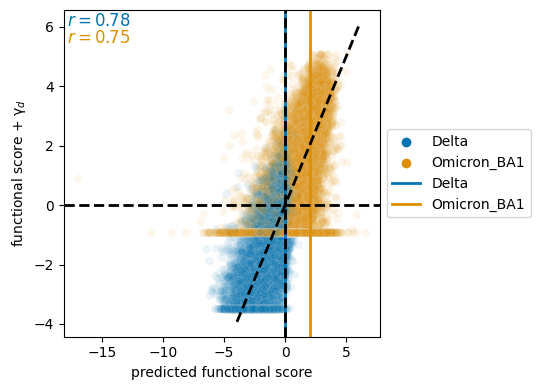

In [173]:
# fig, ax = plt.subplots(figsize=[4,4])
# imodel.plot_pred_accuracy(ax=ax, show=False, alpha=0.08)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

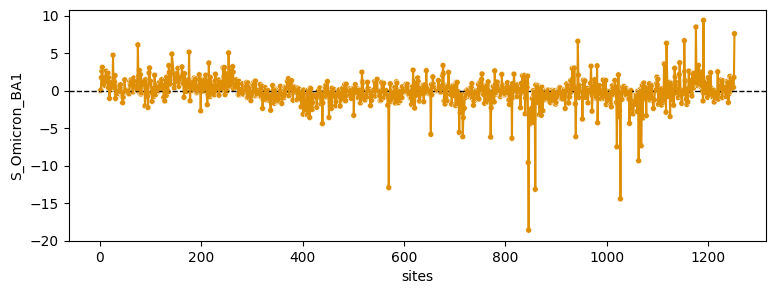

In [174]:
# fig, ax = plt.subplots(figsize=[9,3])
# imodel.plot_shifts_by_site("Omicron_BA1",ax=ax, show=False, agg_func=onp.sum)
# plt.show()

**TODO**
1. Try non linear model.
2. Convergence test comparing models. Does C_ref interfere?

In [107]:
# Finish here, make a loop for all three summmaries

In [150]:
from functools import reduce
def combine_replicate_muts(fit_dict, times_seen_threshold=3):
    """
    Take a dictionary of fit objects, with key's as the prefix for individual
    replicate values, and merge then such that all individual and average mutation
    values are present in both.
    """

    # obtain and curate each of the replicate mutational dataframes
    mutations_dfs = []
    for replicate, fit in fit_dict.items():

        fit_mut_df = fit.mutations_df.set_index("mutation")

        new_column_name_map = {c: f"{replicate}_{c}" for c in fit_mut_df.columns}
        fit_mut_df = fit_mut_df.rename(new_column_name_map, axis=1)

        times_seen_cols = [c for c in fit_mut_df.columns if "times" in c]
        for c in times_seen_cols:
            fit_mut_df = fit_mut_df[fit_mut_df[c] >= times_seen_threshold]
        fit_mut_df.drop(times_seen_cols, axis=1, inplace=True)
        mutations_dfs.append(fit_mut_df)

    # merge each of the replicate mutational dataframes
    mut_df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        mutations_dfs,
    )

    # now compute replicate averages
    for c in fit.mutations_df.columns:
        if c == "mutation" or "times_seen" in c:
            continue
        cols_to_combine = [f"{replicate}_{c}" for replicate in fit_dict.keys()]
        if c in ["wts", "sites", "muts"]:
            mut_df[c] = mut_df[cols_to_combine[0]]
            mut_df.drop(cols_to_combine, axis=1, inplace=True)
        else:
            mut_df[f"avg_{c}"] = mut_df[cols_to_combine].mean(axis=1)

    return mut_df

lasso: 2e-05, max iter: 20000.0


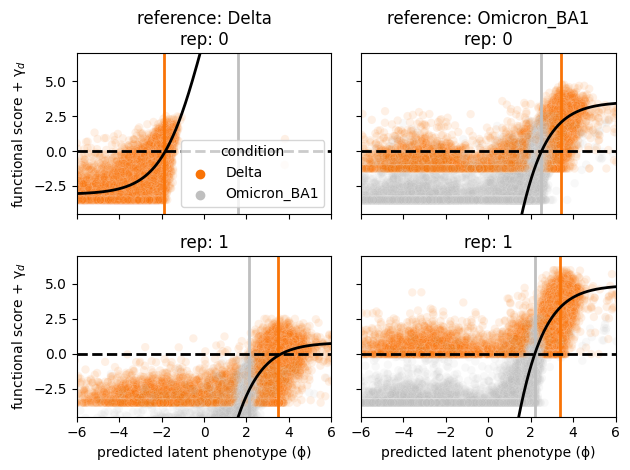

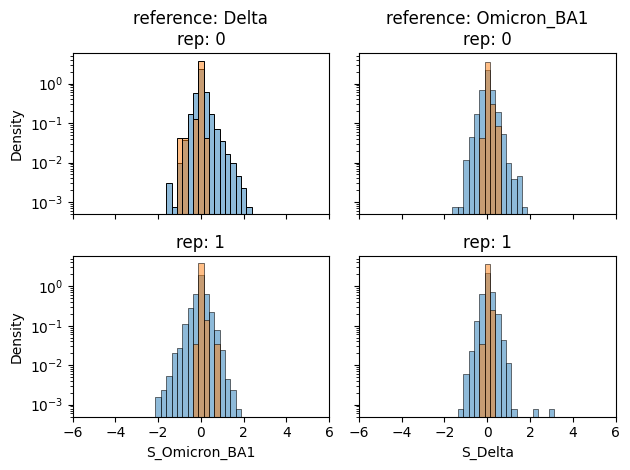

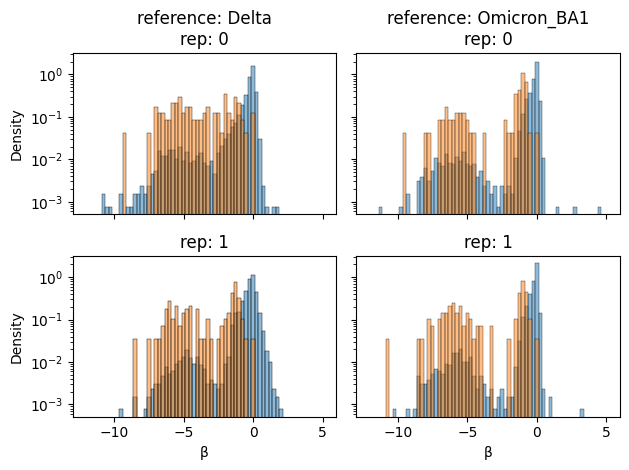

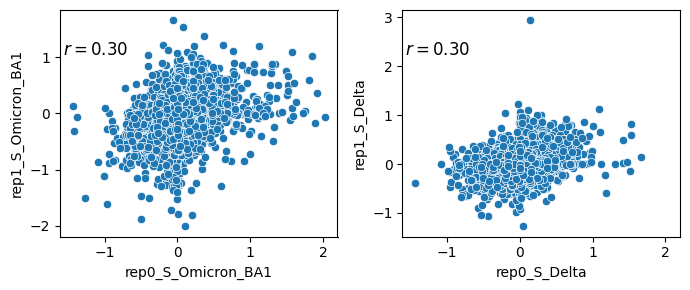

lasso: 5e-05, max iter: 20000.0


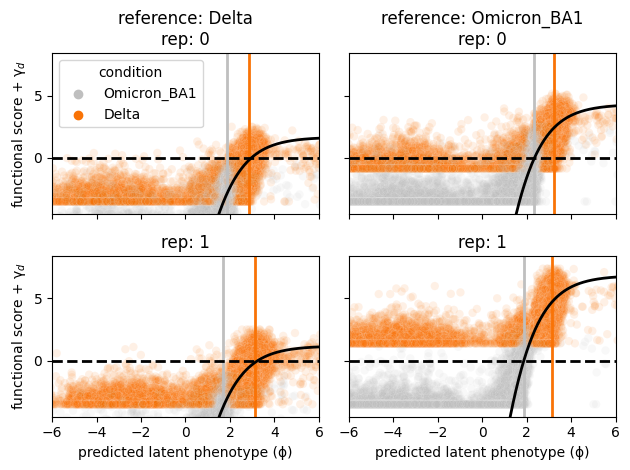

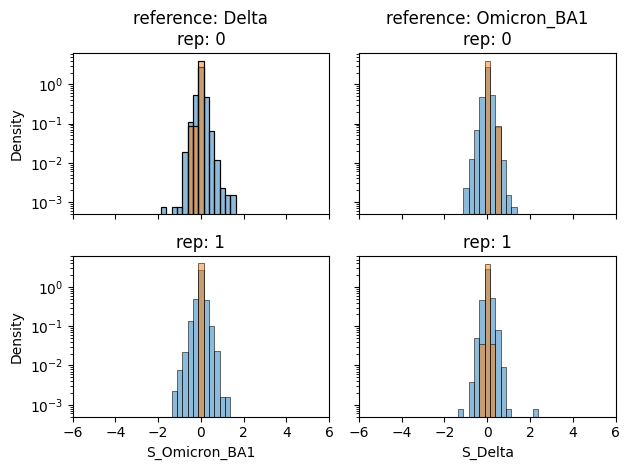

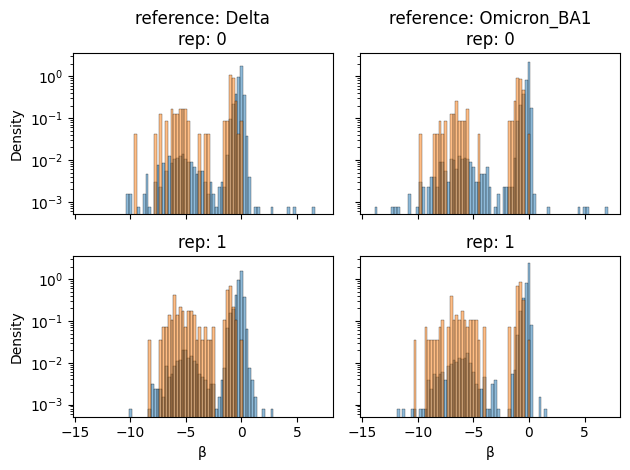

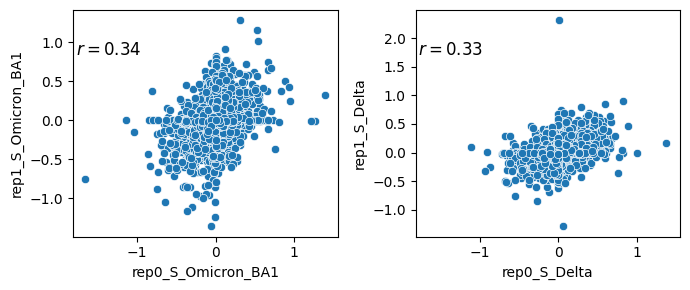

In [197]:
import scipy.stats as st
for lasso_maxiter, lm_models in models.loc[0:19].groupby(["lasso_shift", "maxiter"]):
    
    if lasso_maxiter[1] != 20000: continue
#     print(lm_models)
    
    print(f"lasso: {lasso_maxiter[0]}, max iter: {lasso_maxiter[1]}")
    # epistasis fits
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
    for ref in range(2):
        for rep in range(2):
            fit = lm_models.iloc[(ref*2 + rep), 4]
            shift_params = [f"S_{cond}" for cond in fit.data.conditions if cond != fit.data.reference]
            for sp in shift_params:
                legend = True if rep == 0 and ref == 0 else False 
                fit.plot_epistasis(ax = ax[rep, ref], show=False, legend=legend, alpha=0.10)
                title = f"rep: {rep}"
                if rep == 0: title = f"reference: {fit.data.reference}\n" + title 
                ax[rep, ref].set_title(title)
                ax[rep, ref].set_xlim([-6, 6])
    plt.tight_layout()
    plt.show()
    
    # parameter distribution
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
    for ref in range(2):
        for rep in range(2):
            fit = lm_models.iloc[(ref*2 + rep), 4]
            shift_params = [f"S_{cond}" for cond in fit.data.conditions if cond != fit.data.reference]
            for sp in shift_params:
                legend = True if rep == 0 and ref == 0 else False
                fit.plot_param_hist(sp, ax = ax[rep, ref], show=False, legend=legend)
                title = f"rep: {rep}"
                if rep == 0: title = f"reference: {fit.data.reference}\n" + title
                ax[rep, ref].set_title(title)
                ax[rep, ref].set_xlim([-6, 6])
    plt.tight_layout()
    plt.show()
    
    # Beta's
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
    for ref in range(2):
        for rep in range(2):
            fit = lm_models.iloc[(ref*2 + rep), 4]
#             shift_params = [f"S_{cond}" for cond in fit.data.conditions if cond != fit.data.reference]
#             for sp in shift_params:
            legend = True if rep == 0 and ref == 0 else False
            fit.plot_param_hist("β", ax = ax[rep, ref], show=False, legend=legend)
            title = f"rep: {rep}"
            if rep == 0: title = f"reference: {fit.data.reference}\n" + title
            ax[rep, ref].set_title(title)
#             ax[rep, ref].set_xlim([-6, 6])
    plt.tight_layout()
    plt.show()
    
    # replicate correlation
    fig, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=[7, 3])
    for ref in range(2):
        fit0 = lm_models.iloc[(ref*2), 4]
        fit1 = lm_models.iloc[(ref*2 + 1), 4]
        merged_mut_df = combine_replicate_muts({"rep0":fit0, "rep1":fit1})
        shift_params = [f"S_{cond}" for cond in fit0.data.conditions if cond != fit0.data.reference]
        
        corr = st.pearsonr(
            merged_mut_df[f"rep0_{shift_params[0]}"], 
            merged_mut_df[f"rep1_{shift_params[0]}"]
        )[0]
            
        sns.scatterplot(
            merged_mut_df,
            x=f"rep0_{shift_params[0]}",
            y=f"rep1_{shift_params[0]}",
            ax=ax[ref]
        )
        ax[ref].annotate(
            f"$r = {corr:.2f}$",
            (0.01, .8),
            xycoords="axes fraction",
            fontsize=12
        )
    plt.tight_layout()
    plt.show()

## Heuristic 2

In [187]:

fit_conditions = [
     'Delta-2', 'Delta-3',
     'Omicron_BA1-2', 'Omicron_BA1-3', 
     'Omicron_BA2-1', 'Omicron_BA2-2'
]

fsdf = func_score_df.query("condition in @fit_conditions").copy()

for reference in ["Delta-2", "Omicron_BA1-2"]:     
        
    start = time.time()
    data = multidms.MultiDmsData(
        fsdf,
        alphabet= multidms.AAS_WITHSTOP_WITHGAP,
        condition_colors = sns.color_palette("colorblind"),
        reference=reference,
        assert_site_integrity = False,
        verbose=False
    )

    end = time.time()
    prep_time = round(end-start)
    print(f"Finished, time: {prep_time}")

    prep_params['time_to_prep'] = prep_time
    prep_params['conditions'] = tuple(fsdf.condition.unique())
    prep_params['reference'] = reference
    data_row = pd.Series(prep_params).to_frame().T
    data_row['data'] = data
    datasets = pd.concat([datasets, data_row], ignore_index=True)
    

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 102
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 93


In [188]:
datasets

,scale_counts,min_pre_counts,pseudocount,sample,clip_target,trim,conditions,time_to_prep,reference,data
0,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",29,Delta,<multidms.data.MultiDmsData object at 0x7f52b8...
1,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",26,Delta,<multidms.data.MultiDmsData object at 0x7f51f8...
2,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",25,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f51b4...
3,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",23,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f518c...
4,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",30,Delta,<multidms.data.MultiDmsData object at 0x7f51f8...
5,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",28,Delta,<multidms.data.MultiDmsData object at 0x7f3e40...
6,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",25,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f3d16...
7,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta, Omicron_BA1)",25,Omicron_BA1,<multidms.data.MultiDmsData object at 0x7f3dfd...
8,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta-2, Delta-3, Omicron_BA1-2, Omicron_BA1-...",102,Delta-2,<multidms.data.MultiDmsData object at 0x7f3d05...
9,False,100,0.1,False,"(-3.5, 2.5)",False,"(Delta-2, Delta-3, Omicron_BA1-2, Omicron_BA1-...",93,Omicron_BA1-2,<multidms.data.MultiDmsData object at 0x7f3d04...


In [189]:
import matplotlib.colors as colors

palette = [
    '#F97306', '#FFA500',
    '#BFBFBF','#404040',
    '#9400D3','#EE82EE'
]

conditions = [
    "Delta-2", "Delta-3",
    "Omicron_BA1-2", "Omicron_BA.1-3",
    "Omicron_BA2-1", "Omicron_BA.2-2"
]
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

for row, values in datasets.loc[8:9].iterrows():
    values.data.condition_colors = cc

In [190]:
fit_attributes = {
    "lasso_shift" : 2e-5,
    "maxiter" : 10000
}

for dataset in range(8, 10):
            
    imodel = multidms.MultiDmsModel(
        datasets.loc[dataset, 'data'],
        epistatic_model=multidms.model.sigmoidal_global_epistasis,
        output_activation=multidms.model.softplus_activation
    )

    start = time.time()
    imodel.fit(
        lasso_shift=fit_attributes['lasso_shift'],
        maxiter=fit_attributes['maxiter'], 
        tol=1e-6
    )
    end = time.time()
    fit_time = round(end - start)
    print(f"done. fitting time = {fit_time} seconds")

    fit_attributes["dataset_index"] = int(dataset)
    fit_attributes["fit_time"] = fit_time

    data_row = pd.Series(fit_attributes).to_frame().T
    data_row["model_object"] = imodel
    models = pd.concat([models, data_row], ignore_index=True)

done. fitting time = 389 seconds
done. fitting time = 237 seconds


In [191]:
models

,lasso_shift,maxiter,dataset_index,fit_time,model_object
0,0.00001,10000.0,0.0,133.0,<multidms.model.MultiDmsModel object at 0x7f51...
1,0.00001,10000.0,1.0,113.0,<multidms.model.MultiDmsModel object at 0x7f3d...
2,0.00001,10000.0,2.0,72.0,<multidms.model.MultiDmsModel object at 0x7f3d...
3,0.00001,10000.0,3.0,71.0,<multidms.model.MultiDmsModel object at 0x7f50...
4,0.00005,10000.0,0.0,133.0,<multidms.model.MultiDmsModel object at 0x7f3e...
5,0.00005,10000.0,1.0,111.0,<multidms.model.MultiDmsModel object at 0x7f3e...
6,0.00005,10000.0,2.0,72.0,<multidms.model.MultiDmsModel object at 0x7f3e...
7,0.00005,10000.0,3.0,71.0,<multidms.model.MultiDmsModel object at 0x7f51...
8,0.00005,20000.0,0.0,263.0,<multidms.model.MultiDmsModel object at 0x7f3d...
9,0.00005,20000.0,1.0,221.0,<multidms.model.MultiDmsModel object at 0x7f50...


In [ ]:
multidms.plot.mut_shift_plot(
    {
        "rep1":plot_models.loc[8,"model_object"],
        "rep2":plot_models.loc[1,"model_object"]
    },
    include_beta = False
)

In [88]:
multidms.plot.mut_shift_plot(
    {
        "rep1":plot_models.loc[2,"model_object"],
        "rep2":plot_models.loc[3,"model_object"]
    },
    include_beta = False
)

/home/jgallowa/miniconda3/envs/multidms_toml/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

**Now, we'll try training a model for 10,000 iterations, looking at the fit at every 2,000 iterations.**

In [217]:
fit_attributes = {
    "lasso_shift" : 2e-5
}
            
imodel = multidms.MultiDmsModel(
    datasets.loc[0, 'data'],
    epistatic_model=multidms.model.sigmoidal_global_epistasis,
    output_activation=multidms.model.softplus_activation
)

i=0
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True)
fit_attributes["epoch_loss"] = []
for training_step in range(100):

    start = time.time()
    imodel.fit(
        lasso_shift=fit_attributes['lasso_shift'],
        maxiter=100, 
        tol=1e-6,
        λ_ridge=0
    )
    end = time.time()
    fit_time = round(end - start)
    
    fit_attributes["epoch_loss"].append(imodel.loss)
    print(f"train step {training_step+1} done. time = {fit_time} sec. loss = {imodel.loss}")

    if training_step % 20 == 0:
        imodel.plot_epistasis(legend=False, ax=ax[i], show=False)
        i += 1
        
fit_attributes["dataset_index"] = 0
fit_attributes["fit_time"] = fit_time

data_row = pd.Series(fit_attributes).to_frame().T
data_row["model_object"] = imodel
models = pd.concat([models, data_row], ignore_index=True)

plt.show()

**Next, we'll try applying a small ridge penality to all weights in the model**

In [218]:
fit_attributes = {
    "lasso_shift" : 2e-5
}
            
imodel = multidms.MultiDmsModel(
    datasets.loc[0, 'data'],
    epistatic_model=multidms.model.sigmoidal_global_epistasis,
    output_activation=multidms.model.softplus_activation
)

i=0
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True)
fit_attributes["epoch_loss"] = []
for training_step in range(100):

    start = time.time()
    imodel.fit(
        lasso_shift=fit_attributes['lasso_shift'],
        maxiter=100, 
        tol=1e-6,
        λ_ridge=0
    )
    end = time.time()
    fit_time = round(end - start)
    
    fit_attributes["epoch_loss"].append(imodel.loss)
    print(f"train step {training_step+1} done. time = {fit_time} sec. loss = {imodel.loss}")

    if training_step % 20 == 0:
        imodel.plot_epistasis(legend=False, ax=ax[i], show=False)
        i += 1
        
fit_attributes["dataset_index"] = 0
fit_attributes["fit_time"] = fit_time

data_row = pd.Series(fit_attributes).to_frame().T
data_row["model_object"] = imodel
models = pd.concat([models, data_row], ignore_index=True)

plt.show()